In [ ]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
import networkx
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,)
import itertools
import copy
import networkx as nx
import matplotlib.pyplot as plt
import sys, getopt

In [157]:

def parseTxtFile(name):
    withWeight  = False
    sum=0
    g = nx.Graph()
    with open(name) as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if (lines[i][0]=='-'):
            brk = int(i)
            break
        wl = -1
        prev = False 
        for r in range(len(lines[i])):
            if (lines[i][r]=='-' and not prev):
                fn = r
                prev = True
            if (lines[i][r]!='-' and prev):
                ln = r
                prev = False
            if (lines[i][r]==','):
                wl=r
            if (lines[i][r]=='\n'):
                end = r
        
        if (wl==-1):
            n1 = lines[i][:fn]
            n2 = lines[i][ln:wl]
            g.add_edge(n1,n2, Color='red')
            sum+=1
        else:
            withWeight = True
            n1 = lines[i][:fn]
            n2 = lines[i][ln:wl]
            weight = lines[i][wl+1:end]
            if (int(weight)>=50):
                g.add_edge(n1,n2, Color='red', weight=weight)
                sum+=1
    for i in range(brk+1,len(lines)):
        if (lines[i][0]=='^'):
            brk = i + 1
            break
        for r in range(len(lines[i])):
            if (lines[i][r]=='|'):
                s = r
            if (lines[i][r]==','):
                comma = r
            if (lines[i][r]==')'):
                end = r
            
        node = lines[i][:s]
        x =lines[i][s+2:comma]
        y =lines[i][comma+1:r-1]
        
        g.add_node(node,X=float(x), Y=float(y))
    for r in range(len(lines[brk])):
        if (lines[brk][r]==','):
            comma = r
        if (lines[brk][r]=='\n'):
            end = r
    lines[brk]
    return [g,[int(lines[brk][:comma]), int(lines[brk][comma+1:end])], withWeight]

def plot(g, coor, outFile, withWeight):
    #Establish which categories will appear when hovering over each node
    HOVER_TOOLTIPS = [("Contig", "@index")]

    #Create a plot — set dimensions, toolbar, and title
    plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title='Graph')

    # Define node positions data structure (dict) for plotting
    node_positions = {node[0]: (node[1]['X'], node[1]['Y']) for node in g.nodes(data=True)}
    #print(node_positions)
    # Define data structure (list) of edge colors for plotting
    edge_colors = [e[2]['Color'] for e in g.edges(data=True)]
    cm = 1/2.54
    plt.figure(figsize=(coor[0]*cm, coor[1]*cm))
    nx.draw(g, pos=node_positions, edge_color=edge_colors, node_size=10, node_color='black', with_labels = True, font_size=5)
    if (withWeight):
        labels = {e: g.edges[e]['weight'] for e in g.edges}
        nx.draw_networkx_edge_labels(g,pos=node_positions, edge_labels=labels, font_size=5)
    network_graph = from_networkx(g, node_positions, scale=10, center=(0, 0))
    
    node_hover_tool = HoverTool(renderers=[network_graph.node_renderer], 
                            tooltips=[("Contig", "@index")])
    edge_hover_tool = HoverTool(renderers=[network_graph.edge_renderer], 
                        tooltips=[("weight", "@weight")])
    plot.add_tools(edge_hover_tool, node_hover_tool)
    
    network_graph.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
    network_graph.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
    network_graph.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])

    network_graph.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
    network_graph.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
    network_graph.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)
    
    network_graph.selection_policy = NodesAndLinkedEdges()
    network_graph.inspection_policy = EdgesAndLinkedNodes()
    #Add network graph to the plot
    plot.renderers.append(network_graph)


    show(plot)
    save(plot, filename=outFile+".html")

## Input file

In [158]:
results = parseTxtFile('../../../hifiasm_wg/output_100k_t.txt')

## Output file

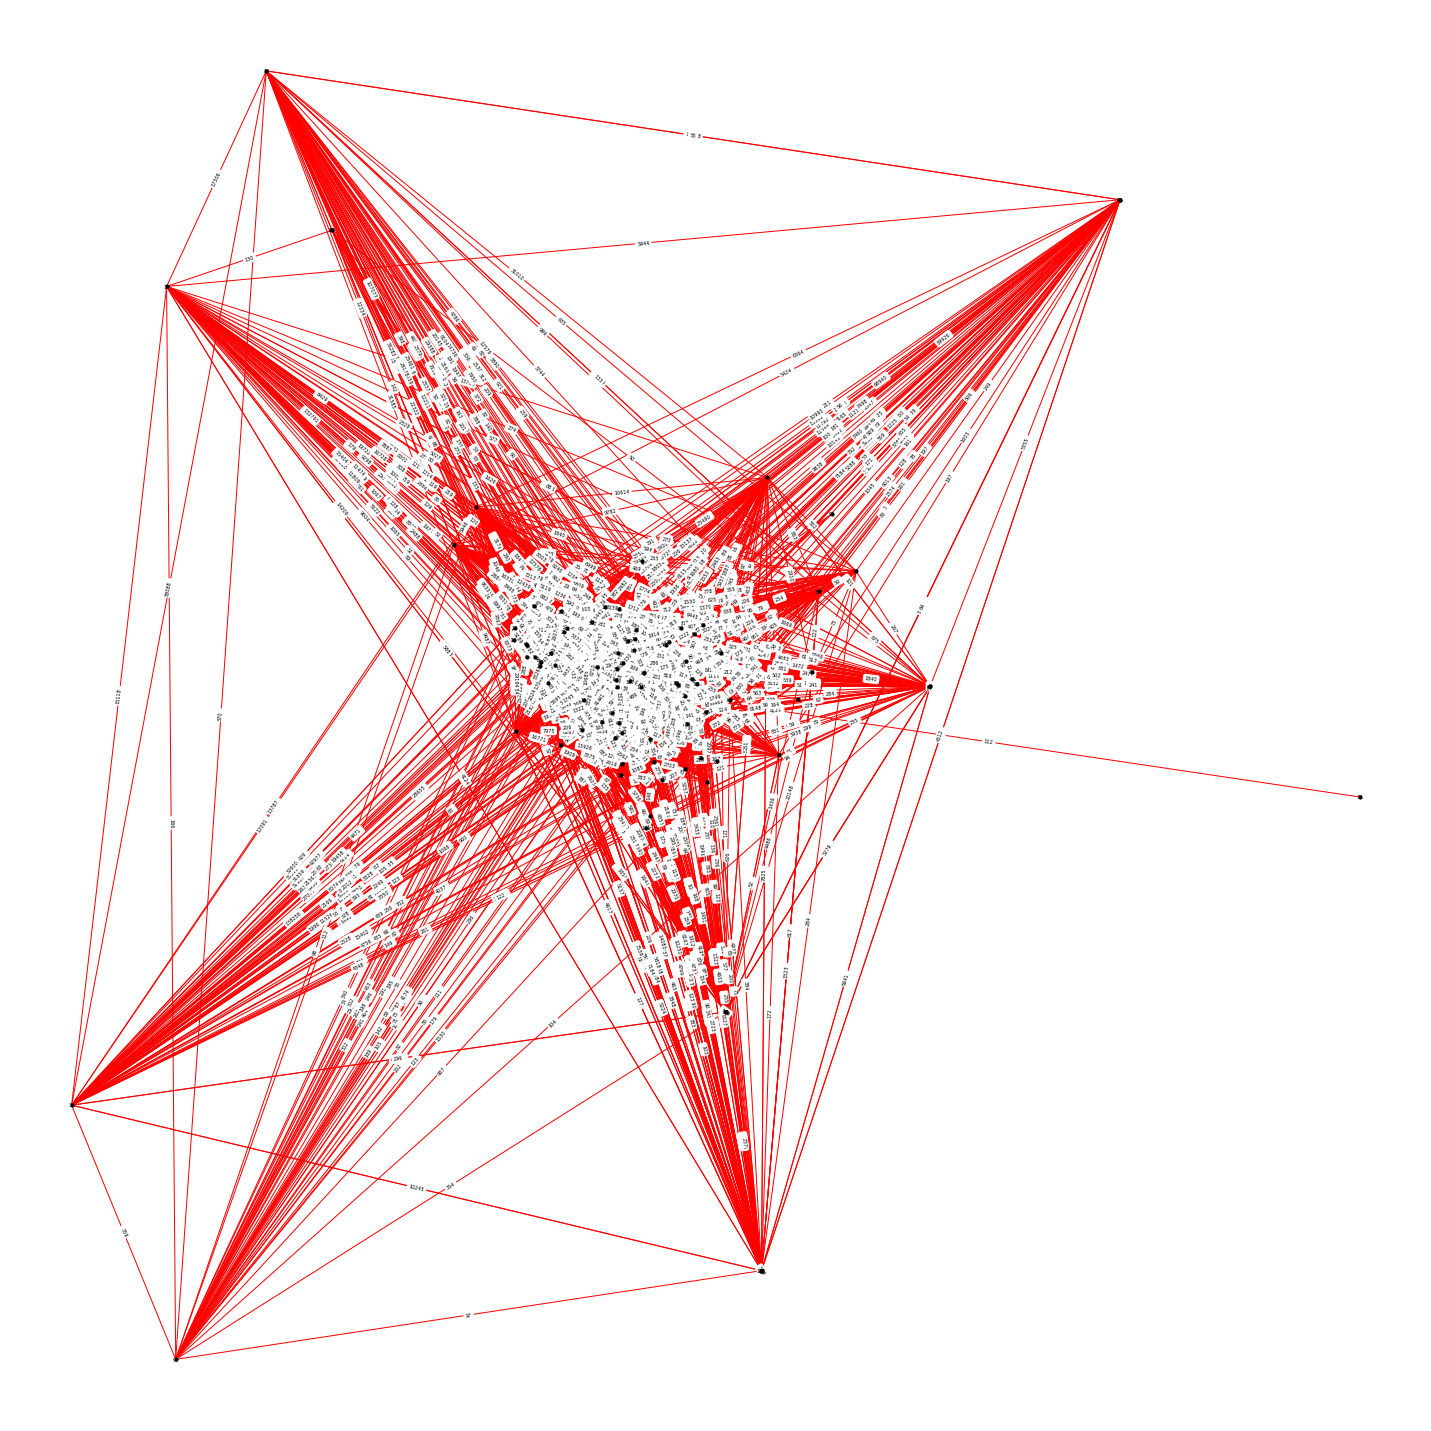

In [159]:
plot(results[0], results[1], '../../../hifiasm_wg/output_100k_t', results[2])